# Artificial Intelligence Course - Fall 1402
## Computer Assignment #2 - Reinforcement Learning

# Table of Contents

- [Part 1: Value Iteration & Policy Iteration Algorithms](#1)
    - [َQuestion 1:](#1-1)
    - [َQuestion 2:](#1-2)
    - [َQuestion 3:](#1-3)
    - [َQuestion 4:](#1-4)
    - [Question 5:](#1-5)
        - [Value Iteration](#1-5-1)
        - [Policy Iteration](#1-5-2)
    - [Question 6:](#1-6)
- [Part 2: Q-Learning Algorithm](#2)
    - [َQuestion 8:](#2-1)
    - [َQuestion 9:](#2-2)
    - [َQuestion 10:](#2-3)

In [1]:
# import
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from time import sleep, time
from typing import *

In [2]:
EPSILON = 0.1
LEARNING_RATE = 0.1
DISCOUNT = 0.9

# Q-learning parameters
REPS = 20
EPISODES = 2000
TIME_LIMIT = 200

DO_RENDER = False
RENDER_FPS = 20

STUDENT_NUM = 573

In [3]:
def monitor_time(f: Callable):
    start = time()
    result = f()
    end = time()
    return result, end - start

## Part 1: Value Iteration & Policy Iteration Algorithms <a name='1'></a>

### Question 1: How does value iteration algorithm find the optimal policy on Markov decision processes(MDPs)? <a name='1-1'></a>

Basically to solve an MDP, it is necessary to find an optimal policy for each state. One way to find it is to solve an $n$-equations-and-$n$-unknowns over utility values of each state where $n$ is the number of states. The equations' form is as follows:
$$ U(s) = 
    \max_{a \in Actions}
        \sum_{s' \in States}
            Pr(s'|s,a) \bigg(R(s, a, s') + \gamma U(s')\bigg)
$$
for all $s \in States$ where $U(s)$ is the utility measure of state $s$, $Pr(s'|s, a)$ is the probability of ending up in $s'$ after taking action $a$ in state $s$, and $R(s, a, s')$ is the reward of taking action $a$ from state $s$ and ending up in $s'$.

Now, Imagine $U_i$ where:
$$ U_{i+1}(s) \leftarrow
    \max_{a \in Actions}
        \sum_{s' \in States}
            Pr(s'|s,a) \bigg(R(s, a, s') + \gamma U_i(s')\bigg) 
$$
and
$$ U_0(s) = 0 $$
with aforementioned definitions for $Pr$ and $R$. It is provable that $U_i(s)$ will converge on a value for each $s \in States$. 

As a result of this convergence, value iteration algorithm thrives. It calculates $U_{i+1}(s)$ for as many times as needed to at last, have the following inequality:
$$\max_{s \in States} |U_{i+1}(s) - U_i(s)| < \theta$$
where $\theta$ is the *error* measure.

Once $U(s)$ values for all $s \in States$ are collected, the optimal policy $\pi(s)$ will be calculated as described below:
$$ \pi(s) = 
    \argmax_{a \in Actions}
        \sum_{s' \in States}
            Pr(s'|s,a) \bigg(R(s, a, s') + \gamma U_i(s')\bigg)
.$$

P.S. for the sake of simplifying and breaking the equations down to understandable pieces, $Q(s, a)$ is frequently used which is defined as follows:
$$ Q(s, a) =
    \sum_{s' \in States}
        Pr(s'|s,a) \bigg(R(s, a, s') + \gamma U(s')\bigg) 
.$$

### Question 2: Complete the given `ValueIterationAgent` class. <a name='1-2'></a>

In [4]:
class ValueIterationAgent:
    def __init__(self: Self, env: gym.Env, discount_factor: float, theta:float=1e-8):
        self.env = env
        self.discount_factor = discount_factor
        self.theta = theta
        self.state_values = np.zeros(env.observation_space.n)
        self.q_values = np.zeros((env.observation_space.n, 
                    env.action_space.n))
        
        self.is_value_estimated = False

    def value_estimation(self: Self):
        if self.is_value_estimated:
            return
        env, state_values, q_values, discount_factor, theta = \
                self.env, \
                self.state_values, \
                self.q_values, \
                self.discount_factor, \
                self.theta
            
        delta = np.inf

        while(delta > theta):
            delta = 0

            for state in range(env.observation_space.n):
                previous_state_value = state_values[state]

                for action in range(env.action_space.n):
                    action_value = 0
                    for probability, next_state, reward, _ in env.unwrapped.P[state][action]:
                        action_value += probability * \
                                (reward + \
                                discount_factor * state_values[next_state])
                    q_values[state, action] = action_value

                state_values[state] = np.max(q_values[state,:])

                delta = np.max([delta, abs(previous_state_value - state_values[state])])
                
        self.is_value_estimated = True

    def take_action(self: Self, action: Any):
        next_state, reward, terminated, truncated, _ = self.env.step(action)
        return next_state, reward, terminated, truncated

    def get_optimal_policy(self: Self, state: Any):
        return np.argmax(self.q_values[state,:])

    def get_state_values(self: Self):
        return self.state_values

    def get_q_values(self: Self):
        return self.q_values

    def reset(self: Self, *args, **kwargs):
        initial_state, _ = self.env.reset(*args, **kwargs)
        return initial_state, False, False
            
    def __repr__(self: Self):
        env = self.env
        nrow, ncol = env.unwrapped.nrow, env.unwrapped.ncol
        n = env.observation_space.n
        
        self.value_estimation()
        to_format = np.vectorize(lambda x: f"{x:.3f}")
        state_values = to_format(self.get_state_values()).reshape(nrow, ncol)
        optimal_policy = np.array([self.get_optimal_policy(state) for state in range(n)]).reshape(nrow, ncol)
        st = "\n".join(["-" * 10,
                "State Utilities:",
                str(state_values),
                "Optimal Policy:",
                str(optimal_policy),
                "-" * 10])
        return st
        
    __str__ = __repr__

### Question 3: How does policy iteration algorithm find the optimal policy on MDPs? <a name='1-3'></a>

In order to find the optimal policy for each state, there is another way rather than solving foretold equations. In policy iteration algorithm we start with a random policy function 
$$ \pi_0: States \rightarrow Actions,$$ 
and 
$$ U^{\pi_0}(s) = 0.$$
In each step thereafter, with the purpose of improving our policy, policy iteration algorithms carry out two procedures:
- **policy evaluation**, which evaluates $U^{\pi_i}$ for each policy,
- **policy improvement**, which improves $\pi_i$ and gives $\pi_{i+1}: States \rightarrow Actions$.

For policy improvement, it uses the following method:
$$ \pi_{i+1}(s) \leftarrow \argmax_{a \in Actions}
    \sum_{s' \in States}
        Pr(s'|s, a) \bigg(R(s, a, s') + \gamma U^{\pi_i}(s)\bigg)
.$$

For policy evaluation, similarly to value iteration, we must solve an $n$-equations-and-$n$-unknowns problem that is as follows:
$$ U^{\pi_i}(s) = \sum_{s' \in States}
    Pr(s'|s, \pi_i(s)) \bigg(R(s, \pi_i(s), s') + \gamma U^{\pi_i}(s)\bigg)
.$$
However, unlike previous equations, this time because there is no non-linear function such as $max$, the equation system is linear and, therefore, soluable by *gaussian elimination method* with $O(n^3)$ time complexity. Even though gaussian elimination method is quite practical in small environments, it takes too long to be carried out on a big one. Thankfully, there is another way.
If we define $U_j^{\pi_i}$ so that:
$$ U_{j+1}^{\pi_i}(s) \leftarrow \sum_{s' \in States}
    Pr(s'|s, \pi_i(s)) \bigg(R(s, \pi_i(s), s') + \gamma U_j^{\pi_i}(s)\bigg)
,$$
where $\forall s \in States\bigg(U_0^{\pi_i}(s) = 0\bigg)$, it is provable that $U_j^{\pi_i}$ converges on the answer of the equations. This procedure is called *simplified value iteration* and if a policy iteration algorithm uses it, it will be called a *modified policy iteration algorithm*.
In this assignment, the second approach is used.

### Question 4: Complete the given `ModifiedPolicyIterationAgent` class. <a name='1-4'></a>

In [5]:
class ModifiedPolicyIterationAgent():
    def __init__(self: Self, env: gym.Env, discount_factor:float, theta:float=1e-8):
        self.env = env
        self.discount_factor = discount_factor
        self.theta = theta
        self.state_values = np.zeros((env.observation_space.n))
        self.q_values = np.zeros((env.observation_space.n, env.action_space.n))
        self.policy = np.random.randint(env.action_space.n, size=env.observation_space.n)
        self.policy_stable = False

    def policy_evaluation(self):
        env, discount_factor, theta, state_values, policy = self.env, \
                self.discount_factor, \
                self.theta, \
                self.state_values, \
                self.policy
        delta = np.inf

        while(delta > theta):

            delta = 0

            for state in range(env.observation_space.n):

                previous_state_value = state_values[state]

                new_state_value = 0
                for probability, next_state, reward, _ in env.unwrapped.P[state][policy[state]]:
                    new_state_value += probability * \
                                (reward + \
                                discount_factor * state_values[next_state])
                state_values[state] = new_state_value

                delta = np.max([delta, abs(previous_state_value - new_state_value)])

    def policy_improvement(self: Self):
        env, discount_factor, state_values, q_values, policy = self.env, \
                self.discount_factor, \
                self.state_values, \
                self.q_values, \
                self.policy
        
        is_policy_stable = True
        for state in range(env.observation_space.n):
            old_policy = policy[state]

            for action in range(env.action_space.n):

                action_value = 0
                for probability, next_state, reward, _ in env.unwrapped.P[state][action]:
                    action_value += probability * \
                                (reward + \
                                discount_factor * state_values[next_state])
                q_values[state, action] = action_value

            policy[state] = np.argmax(q_values[state,:])

            if old_policy != policy[state]:
                is_policy_stable = False
        
        self.policy_stable = is_policy_stable

    def policy_estimation(self: Self):
        
        while not self.policy_stable:
            self.policy_evaluation()
            self.policy_improvement()

    def take_action(self: Self, action: Any):
        next_state, reward, terminated, truncated, _ = self.env.step(action)
        return next_state, reward, terminated, truncated

    def get_optimal_policy(self: Self, state):
        return self.policy[state]

    def get_state_values(self: Self):
        return self.state_values

    def get_q_values(self: Self):
        return self.q_values

    def reset(self: Self, *args, **kwargs):
        initial_state, _ = self.env.reset(*args, **kwargs)
        return initial_state, False, False
            
    def __repr__(self: Self):
        env, policy = self.env, self.policy
        nrow, ncol = env.unwrapped.nrow, env.unwrapped.ncol
        n = env.observation_space.n
        
        self.policy_estimation()
        to_format = np.vectorize(lambda x: f"{x:.3f}")
        state_values = to_format(self.get_state_values()).reshape(nrow, ncol)
        optimal_policy = np.array(policy).reshape(nrow, ncol)
        st = "\n".join(["-" * 10,
                "State Utilities:",
                str(state_values),
                "Optimal Policy:",
                str(optimal_policy),
                "-" * 10])
        return st
        
    __str__ = __repr__

### Question 5: Run both algorithms on the Frozen Lake environment. <a name='1-5'></a>

#### Value Iteration: <a name='1-5-1'></a>

In [6]:
env = gym.make('FrozenLake-v1', 
        desc=None, 
        map_name="4x4", 
        is_slippery=True,)

agent = ValueIterationAgent(env, DISCOUNT)
agent.value_estimation()
agent


----------
State Utilities:
[['0.069' '0.061' '0.074' '0.056']
 ['0.092' '0.000' '0.112' '0.000']
 ['0.145' '0.247' '0.300' '0.000']
 ['0.000' '0.380' '0.639' '0.000']]
Optimal Policy:
[[0 3 0 3]
 [0 0 0 0]
 [3 1 0 0]
 [0 2 1 0]]
----------

#### Policy Iteration: <a name='1-5-2'></a>

In [7]:
env = gym.make('FrozenLake-v1', 
        desc=None, 
        map_name="4x4", 
        is_slippery=True)

agent = ModifiedPolicyIterationAgent(env, DISCOUNT)
agent.policy_estimation()
agent

----------
State Utilities:
[['0.069' '0.061' '0.074' '0.056']
 ['0.092' '0.000' '0.112' '0.000']
 ['0.145' '0.247' '0.300' '0.000']
 ['0.000' '0.380' '0.639' '0.000']]
Optimal Policy:
[[0 3 0 3]
 [0 0 0 0]
 [3 1 0 0]
 [0 2 1 0]]
----------

### Question 6: Compare the returned state values and policies of Value Iteration and Policy Iteration. Next, answer which one has been quicker.<a name='1-6'></a>

As shown in the previous section, state utility values alongside optimal policies for both algorithms have converged on a single value — which is intuitively obvious since if they had converged to two different values, it would have been contradictory to the very definition of convergence itself.

Also, to be able to measure the time taken by each agent to provide the optimal policy, each will be run $N$ times, every time assessed by the `monitor_time` function. This function is designed to return any function's running duration. Next, these assessments will be averaged and printed:

In [8]:
N = 100
average_value_estimation_time = 0
average_policy_estimation_time = 0
for i in range(N):
    env = gym.make('FrozenLake-v1', 
            desc=None, 
            map_name="4x4", 
            is_slippery=True)

    value_iterative_agent = ValueIterationAgent(env, DISCOUNT)
    policy_iterative_agent = ModifiedPolicyIterationAgent(env, DISCOUNT)
    
    _, value_estimation_time = monitor_time(lambda: value_iterative_agent.value_estimation())
    _, policy_estimation_time = monitor_time(lambda: policy_iterative_agent.policy_estimation())
    
    average_value_estimation_time += value_estimation_time
    average_policy_estimation_time += policy_estimation_time
    
average_value_estimation_time /= N
average_policy_estimation_time /= N

average_value_estimation_time, average_policy_estimation_time

(0.037516562938690184, 0.04498790740966797)

As you can see, in this special case Value Iteration algorithm wins the race by quite a small margin.

To close the first part in style, a graphical representation of an agent taking the optimal policy to the goal is provided.

In [9]:
if DO_RENDER:
    env = gym.make('FrozenLake-v1', 
            desc=None, 
            map_name="4x4", 
            is_slippery=True,
            render_mode='human' if DO_RENDER else None)
    env.metadata['render_fps'] = RENDER_FPS

    agent = ValueIterationAgent(env, DISCOUNT)
    agent.value_estimation()
    state, terminated, truncated = agent.reset(seed=STUDENT_NUM)
    try:
        while not (terminated or truncated):
            action = agent.get_optimal_policy(state)
            state, _, terminated, truncated = agent.take_action(action) 
            env.render()
    finally:
        env.close()

## Part 2: Q-Learning Algorithm <a name='2'></a>

### Question 7: How does Temporal-Difference Q-Learning algorithm work? <a name='2-7'></a>

Q-Learning algorithm learns Q-value of each $(state, action)$ by applying the following assignment every time action $a$ is perceived that transitions $s$ to $s'$: ($Q(s, a)$ is initially zero for all $(state, action)$)
$$ Q(s, a) \leftarrow (1 - \alpha)Q(s, a) + \alpha(R(s, a, s') + \gamma \max_{a'} Q(s', a') - Q(s, a)) $$
where $\alpha$ and $\gamma$ are the learning rate and the discounting factor respectively. The naming comes from teaching the agent by adding the temporal difference, $[R(s, a, s') + \gamma \max_{a'} Q(s', a') - Q(s, a)]$, to the Q-table.  
After $Q(s, a)$ is updated, Q-value for all $s''\in States$ and $a''\in Actions$ should be re-estimated to be compatible with the new percept.  
Next, optimal policy $\pi^*$ for each $s\in States$ is evaluated the following way:
$$ \pi^*(s) = \max_{a\in Actions} Q(s, a) $$
which if taken will maximize $Q(s, a)$ for all the percepts received.

### Question 8: Complete the given `QLearningAgent` class. <a name='2-8'></a>

In [10]:
class QLearningAgent:
    def __init__(self: Self, 
                env: gym.Env, 
                epsilon: float, 
                learning_rate: float, 
                discount_factor: float, 
                seed: int):
        self.env = env
        self.epsilon = epsilon
        self.learning_rate = learning_rate
        self.olr = learning_rate
        self.discount_factor = discount_factor
        self.q_table = np.zeros((env.observation_space.n, env.action_space.n))
        self.seed = seed
        self.rng = np.random.default_rng()

    def choose_action(self: Self, state: int):
        env, epsilon, q_table, rng = self.env, self.epsilon, self.q_table, self.rng
        
        decision = rng.random() <= epsilon
        action = rng.integers(env.action_space.n) if decision else np.argmax(q_table[state])
        
        return action

    def update_q_table(self: Self, state: int, action: int, next_state: int, reward: float):
        a, q_table, discount = self.learning_rate, self.q_table, self.discount_factor
        q_table[state, action] = (1 - a) * q_table[state, action] \
                + a * (\
                        (reward + discount * np.max(q_table[next_state])) \
                        - q_table[state, action])

    def decay_epsilon(self: Self, episode: int):
        self.epsilon *= 1 - episode / EPISODES

    def decrease_learning_rate(self: Self, episode: int):
        pass

    def take_action(self: Self, action: int):
        next_state, reward, terminated, truncated, _ = self.env.step(action)
        return next_state, reward, terminated, truncated

    def get_optimal_policy(self: Self, state: int):
        return np.argmax(self.q_table[state])

    def get_q_values(self: Self):
        return self.q_table

    def reset(self: Self):
        initial_state, _ = self.env.reset(seed=self.seed, )
        return initial_state, False, False
            
    def __repr__(self: Self):
        env = self.env
        nrow, ncol, npass, nact = 5, 5, 5, 4
        n = env.observation_space.n
        q_values = self.get_q_values()
        
        to_format = np.vectorize(lambda x: f"{x:.3f}")
        state_values = to_format(np.max(q_values, axis=1)).reshape(nrow, ncol, npass, nact)
        optimal_policy = np.argmax(q_values, axis=1).reshape(nrow, ncol, npass, nact)
        st = "\n".join(["-" * 10,
                "State Utilities:",
                str(state_values),
                "Optimal Policy:",
                str(optimal_policy),
                "-" * 10])
        return st
        
    __str__ = __repr__

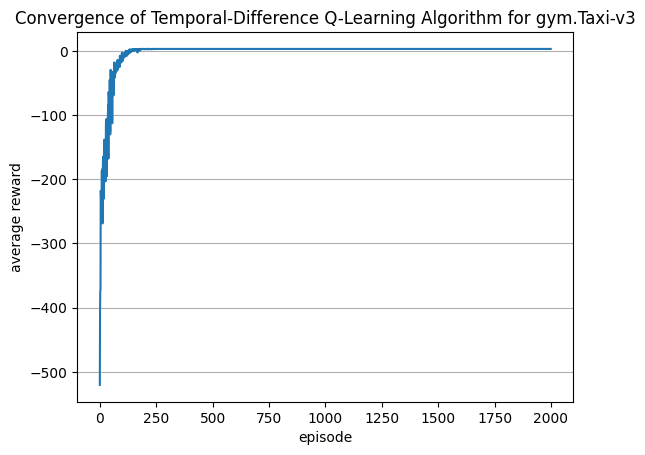

In [16]:
env = gym.wrappers.TimeLimit(gym.make('Taxi-v3'), TIME_LIMIT)
reward_sum = np.zeros((REPS, EPISODES))
for rep in range(REPS):
    agent = QLearningAgent(env, EPSILON, LEARNING_RATE, DISCOUNT, STUDENT_NUM)
    for episode in range(EPISODES):
        state, terminated, truncated = agent.reset()
        
        while not (terminated or truncated):
            action = agent.choose_action(state)
            next_state, reward, terminated, truncated = agent.take_action(action)
            reward_sum[rep, episode] += reward
            
            agent.update_q_table(state, action, next_state, reward)
            agent.decay_epsilon(episode)
            agent.decrease_learning_rate(episode)
            
            state = next_state
fig, ax = plt.subplots()
ax.plot(np.arange(EPISODES), np.average(reward_sum, axis=0))
ax.grid(True, axis='y')
ax.set_xlabel('episode')
ax.set_ylabel('average reward')
ax.set_title('Convergence of Temporal-Difference Q-Learning Algorithm for gym.Taxi-v3')
plt.show()


In [12]:
if DO_RENDER:
    env = gym.make('Taxi-v3', render_mode='human')
    env.metadata['render_fps'] = RENDER_FPS
    
    state, _ = env.reset(seed=STUDENT_NUM)
    terminated, truncated = False, False
    try:
        while not (terminated or truncated):
            action = agent.choose_action(state)
            state, _, terminated, truncated, _ = env.step(action)
    finally:
        env.close()

<a name='2-2'></a>
### Question 9:

<a name='2-3'></a>
### Question 10: